In [1]:
# Data Preprocessing Template
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO

In [2]:
column_list = []
column_list.append('failure')
column_list.append('model')
column_list.append('serial_number')
column_list.append('smart_5_raw')
column_list.append('smart_9_raw')
column_list.append('smart_184_raw')
column_list.append('smart_187_raw')
column_list.append('smart_193_raw')
column_list.append('smart_197_raw')
column_list.append('smart_198_raw')
column_list.append('smart_240_raw')
column_list.append('smart_241_raw')
column_list.append('smart_242_raw')

In [3]:
# Load the entire dataset into a pandas dataframe

df = pd.read_parquet('/nobackup/amimalik/bits/dataset/dimensions/4Q/failed_devices_df_all.parquet', columns=column_list)

In [4]:
df.shape

(689455, 13)

In [5]:
df.head()

,failure,model,serial_number,smart_5_raw,smart_9_raw,smart_184_raw,smart_187_raw,smart_193_raw,smart_197_raw,smart_198_raw,smart_240_raw,smart_241_raw,smart_242_raw
750,0.0,ST4000DM000,W300R8BM,0.0,69104.0,0.0,0.0,11874.0,0.0,0.0,69065.0,6.313640e+10,3.751740e+11
994,0.0,ST4000DM000,Z302BN64,0.0,71397.0,0.0,0.0,56662.0,0.0,0.0,71195.0,7.817508e+10,4.160596e+11
1052,0.0,ST4000DM000,Z302A194,0.0,71383.0,0.0,0.0,54425.0,0.0,0.0,71194.0,7.787505e+10,4.734269e+11
1120,0.0,ST4000DM000,Z302ALE1,0.0,71392.0,0.0,0.0,56824.0,0.0,0.0,71199.0,7.733693e+10,6.256444e+11
1142,0.0,ST4000DM000,Z302B0W7,0.0,71390.0,0.0,0.0,57077.0,0.0,0.0,71190.0,7.561152e+10,5.654197e+11


In [6]:
# find the serial numbers of the drive by counting the number of times each serial number appears in the dataset
serial_number_counts = df['serial_number'].value_counts()

In [7]:
serial_number_counts.describe()

count    4406.000000
mean      156.480935
std       107.548077
min         1.000000
25%        54.000000
50%       150.000000
75%       243.000000
max       364.000000
Name: count, dtype: float64

In [8]:
top_75_percent = serial_number_counts[serial_number_counts >= serial_number_counts.quantile(0.75)]

top_75_percent.head()

serial_number
6190A04AF97G    364
ZL22ZHME        364
9860A01HF97G    363
ZHZ3P3GX        363
87DFWOG8T       363
Name: count, dtype: int64

In [9]:
# Get the list of serial numbers from serial_numbers_gt_50
serial_numbers = top_75_percent.index.tolist()

# Find all instances and features from df based on the serial numbers
instances = df[df['serial_number'].isin(serial_numbers)]

In [10]:
instances.shape

(335601, 13)

In [11]:
instances.head()

,failure,model,serial_number,smart_5_raw,smart_9_raw,smart_184_raw,smart_187_raw,smart_193_raw,smart_197_raw,smart_198_raw,smart_240_raw,smart_241_raw,smart_242_raw
4175,0.0,ST4000DM000,Z302AKQM,0.0,69022.0,0.0,3.0,39866.0,0.0,0.0,68860.0,7.404265e+10,4.167965e+11
4178,0.0,ST4000DM000,Z302AYMF,0.0,69023.0,0.0,0.0,35867.0,0.0,0.0,68877.0,7.469578e+10,4.342874e+11
7430,0.0,ST4000DM000,Z302SZ55,0.0,66667.0,0.0,0.0,21117.0,0.0,0.0,66509.0,7.332490e+10,4.475221e+11
7477,0.0,ST4000DM000,Z302SZ32,0.0,66667.0,0.0,0.0,20176.0,0.0,0.0,66544.0,7.512538e+10,4.291408e+11
7657,0.0,ST4000DM000,Z302SXQ5,0.0,66662.0,0.0,0.0,22640.0,0.0,0.0,66528.0,7.796091e+10,1.095578e+12


In [12]:
instances.columns

Index(['failure', 'model', 'serial_number', 'smart_5_raw', 'smart_9_raw',
       'smart_184_raw', 'smart_187_raw', 'smart_193_raw', 'smart_197_raw',
       'smart_198_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw'],
      dtype='object')

In [13]:
raw_columns = [col for col in instances.columns if 'raw' in col]
ddf = instances.copy()

print(raw_columns)

['smart_5_raw', 'smart_9_raw', 'smart_184_raw', 'smart_187_raw', 'smart_193_raw', 'smart_197_raw', 'smart_198_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw']


In [14]:
# Get the columns that contain "raw" in their name
raw_columns = [col for col in ddf.columns if 'raw' in col]

# Calculate the z-score for each raw column and store the values in new columns with the postfix "norm"
for col in raw_columns:
    norm_col = col.replace("raw", "norm")
    ddf[norm_col] = (ddf[col] - ddf[col].min()) / (ddf[col].max() - ddf[col].min())

# Drop columns with "raw" in their name
drop_column_list = [col for col in ddf.columns if 'raw' in col]
ddf = ddf.drop(drop_column_list, axis=1)

# Print the updated dataframe
ddf.head(10)

,failure,model,serial_number,smart_5_norm,smart_9_norm,smart_184_norm,smart_187_norm,smart_193_norm,smart_197_norm,smart_198_norm,smart_240_norm,smart_241_norm,smart_242_norm
4175,0.0,ST4000DM000,Z302AKQM,0.000000,0.912109,0.0,0.000046,0.164372,0.000000,0.000000,0.911727,0.263125,0.071850
4178,0.0,ST4000DM000,Z302AYMF,0.000000,0.912122,0.0,0.000000,0.147883,0.000000,0.000000,0.911952,0.265446,0.074865
7430,0.0,ST4000DM000,Z302SZ55,0.000000,0.880988,0.0,0.000000,0.087066,0.000000,0.000000,0.880599,0.260574,0.077147
7477,0.0,ST4000DM000,Z302SZ32,0.000000,0.880988,0.0,0.000000,0.083186,0.000000,0.000000,0.881062,0.266972,0.073978
7657,0.0,ST4000DM000,Z302SXQ5,0.000000,0.880922,0.0,0.000000,0.093346,0.000000,0.000000,0.880851,0.277049,0.188863
7674,0.0,ST4000DM000,Z302SYWC,0.000000,0.880935,0.0,0.000000,0.080106,0.000000,0.000000,0.881062,0.290721,0.191524
11168,0.0,ST4000DM000,Z3041H7Z,0.000000,0.859778,0.0,0.000000,0.043640,0.000000,0.000000,0.860381,0.247201,0.099554
11425,0.0,ST4000DM000,S301GQAL,0.000000,0.859686,0.0,0.000229,0.029304,0.000052,0.000052,0.860500,0.251894,0.071155
11491,0.0,ST4000DM000,S301GV8P,0.031864,0.859673,0.0,0.000290,0.067798,0.000017,0.000017,0.859904,0.247122,0.077282
11535,0.0,ST4000DM000,Z304KQPD,0.000000,0.859712,0.0,0.000000,0.044081,0.000000,0.000000,0.860341,0.245081,0.073598


In [15]:
ddf.rename(columns={'failure':'failure', 'smart_5_norm':'Reallocated_Sectors_Count', 'smart_9_norm':'Power-On_Hours',
                    'smart_184_norm':'I/O_Error_Detection_and_Correction','smart_187_norm':'Reported_Uncorrectable_Errors', 
                    'smart_193_norm':'Load_Unload_Cycle', 'smart_197_norm':'Current_Pending_Sector_Count', 'smart_198_norm':'Offline_Uncorrectable',
                    'smart_240_norm':'Head_Flying_Hours', 'smart_241_norm':'Total_LBAs_Written', 'smart_242_norm':'Total_LBAs_Read'}, inplace=True)

In [16]:
ddf.head()

,failure,model,serial_number,Reallocated_Sectors_Count,Power-On_Hours,I/O_Error_Detection_and_Correction,Reported_Uncorrectable_Errors,Load_Unload_Cycle,Current_Pending_Sector_Count,Offline_Uncorrectable,Head_Flying_Hours,Total_LBAs_Written,Total_LBAs_Read
4175,0.0,ST4000DM000,Z302AKQM,0.0,0.912109,0.0,0.000046,0.164372,0.0,0.0,0.911727,0.263125,0.071850
4178,0.0,ST4000DM000,Z302AYMF,0.0,0.912122,0.0,0.000000,0.147883,0.0,0.0,0.911952,0.265446,0.074865
7430,0.0,ST4000DM000,Z302SZ55,0.0,0.880988,0.0,0.000000,0.087066,0.0,0.0,0.880599,0.260574,0.077147
7477,0.0,ST4000DM000,Z302SZ32,0.0,0.880988,0.0,0.000000,0.083186,0.0,0.0,0.881062,0.266972,0.073978
7657,0.0,ST4000DM000,Z302SXQ5,0.0,0.880922,0.0,0.000000,0.093346,0.0,0.0,0.880851,0.277049,0.188863


In [17]:
ddf.to_parquet("/nobackup/amimalik/bits/dataset/dimensions/4Q/working_dataset.parquet")

In [18]:
drop_column_list = []
drop_column_list.append('model')
drop_column_list.append('serial_number')
ddf = ddf.drop(drop_column_list, axis=1)

In [19]:
ddf.columns

Index(['failure', 'Reallocated_Sectors_Count', 'Power-On_Hours',
       'I/O_Error_Detection_and_Correction', 'Reported_Uncorrectable_Errors',
       'Load_Unload_Cycle', 'Current_Pending_Sector_Count',
       'Offline_Uncorrectable', 'Head_Flying_Hours', 'Total_LBAs_Written',
       'Total_LBAs_Read'],
      dtype='object')

In [20]:
ddf.describe()

,failure,Reallocated_Sectors_Count,Power-On_Hours,I/O_Error_Detection_and_Correction,Reported_Uncorrectable_Errors,Load_Unload_Cycle,Current_Pending_Sector_Count,Offline_Uncorrectable,Head_Flying_Hours,Total_LBAs_Written,Total_LBAs_Read
count,335601.000000,334989.000000,335565.000000,75554.000000,198402.000000,332253.000000,327646.000000,334091.000000,250414.000000,211248.000000,211248.000000
mean,0.003313,0.012449,0.462150,0.000188,0.001937,0.044132,0.000079,0.000071,0.402311,0.361636,0.075837
std,0.057467,0.070580,0.209453,0.010571,0.040724,0.092591,0.004312,0.004268,0.288616,0.112934,0.042411
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.311789,0.000000,0.000000,0.004408,0.000000,0.000000,0.223893,0.324734,0.059132
50%,0.000000,0.000000,0.420282,0.000000,0.000000,0.007323,0.000000,0.000000,0.383135,0.366318,0.075857
75%,0.000000,0.000122,0.574829,0.000000,0.000076,0.017829,0.000000,0.000000,0.686231,0.396005,0.086822
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
print(ddf.isnull().sum())

failure                                    0
Reallocated_Sectors_Count                612
Power-On_Hours                            36
I/O_Error_Detection_and_Correction    260047
Reported_Uncorrectable_Errors         137199
Load_Unload_Cycle                       3348
Current_Pending_Sector_Count            7955
Offline_Uncorrectable                   1510
Head_Flying_Hours                      85187
Total_LBAs_Written                    124353
Total_LBAs_Read                       124353
dtype: int64


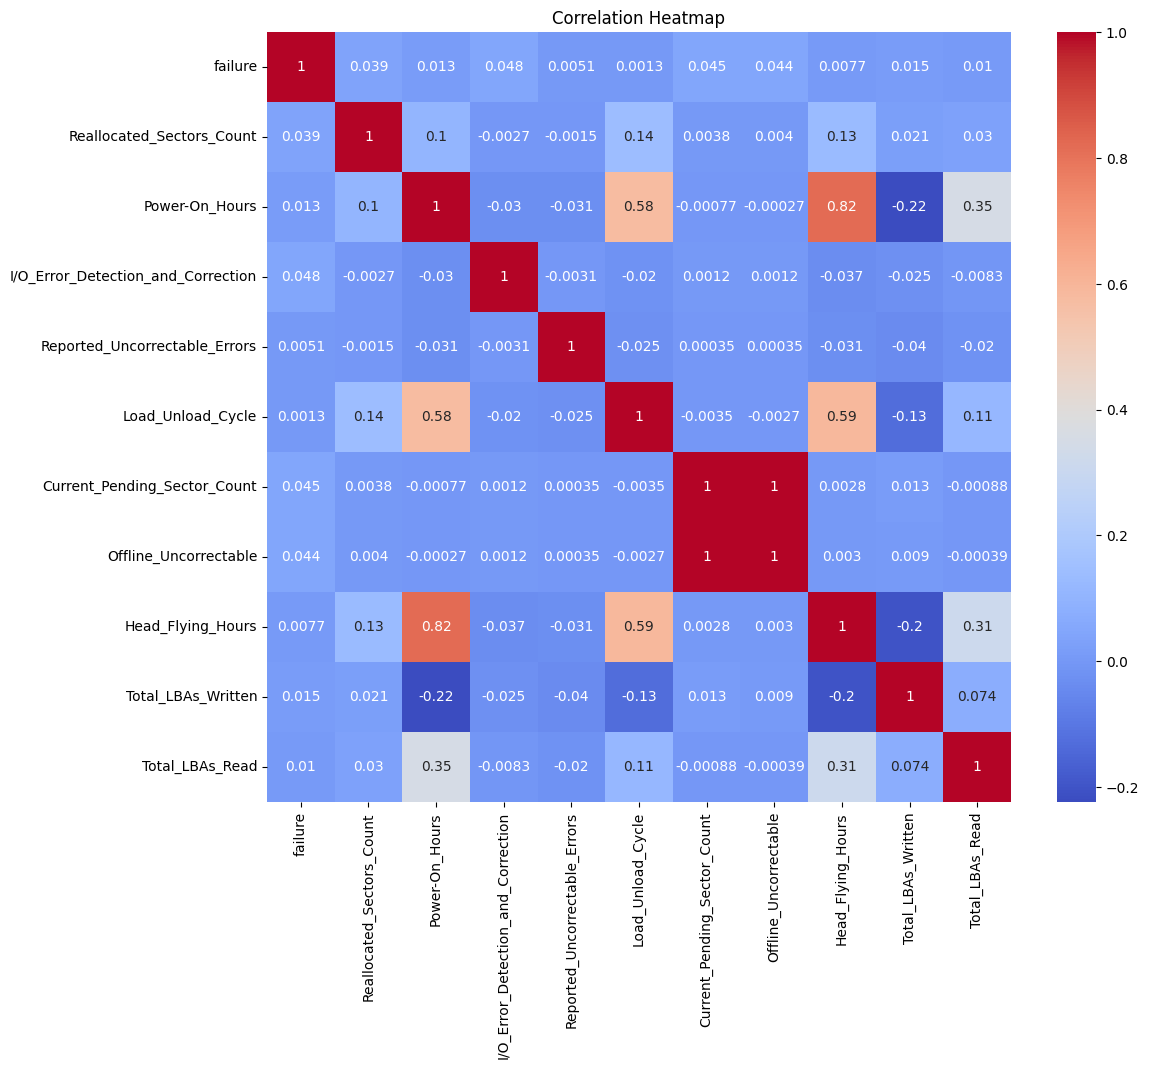

In [22]:
# Create a correlation matrix
corr_matrix = ddf.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title and display the plot
plt.title('Correlation Heatmap')
plt.show()